# EVAC Examination

## Data Exploration

In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [411]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 64
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_79663/3200560116.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [412]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


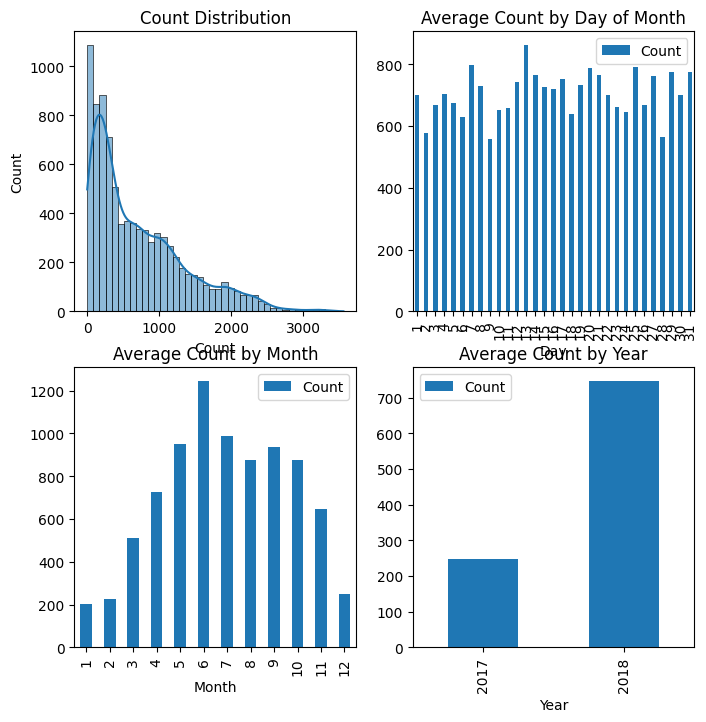

In [413]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [414]:
all_data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [415]:
!pip install deap

389073.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [416]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [417]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = evdata['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [418]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [419]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [420]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [421]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


35040
140160


In [422]:
def eval(individual, myNet, evdata):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(evdata)):
    input = [ evdata['Windspeed'][i], evdata['Visibility'][i], evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i]]
    output = myNet.feedForward(input)
    if output[0] < 0:
      return 1000000000000000,
    fitness += abs(evdata['Count'][i] - output[0])
  return fitness/len(evdata),


In [423]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.6)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet, train_data)
print(baseline)

(1000000000000000,)


In [424]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [425]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[0.3027662325400292, 0.39187517428403584, 0.6780561028542769, 0.13896133398850363, 0.3491482349544246, 0.5322500298303712, 0.4856192558513851, 0.8776518159978252, 0.7982142522325266, 0.47894425196150536, 0.6760020422584969, 0.3547015564107221, 0.8868642604367714, 0.6737119293174488, 0.5673105779786407, 0.5585227006385236, 0.4787942226015627, 0.10966697516713808, 0.3304011202013568, 0.36900187008611196, 0.8974772509027158, 0.25034614302277525, 0.5811074527860896, 0.18281960024867183, 0.858170927668619, 0.6820601091958179, 0.04626437610407508, 0.7330842906140831, 0.25834147588417655, 0.9449264610940131, 0.765367561261936, 0.06552352156155261, 0.5102925572929926, 0.5690721829853075, 0.23701516638690068, 0.5725692577216436, 0.30123936934602336, 0.6524311436766668, 0.31174434350712776, 0.36873600063689116, 0.6471533652115323, 0.7370758730979197, 0.48636069224363065, 0.6668311706920378, 0.8993316866085266, 0.09874309454000663, 0.7711662410543045, 0.31806387886284726, 0.6752017007448197, 0.12

True
None
[186.75849088]
(26519.489924930298,)


In [426]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [427]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [428]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [429]:
print(logbook)
# import pygraphviz as pgv
# from IPython.display import Image
# best_ind = tools.selBest(pop, 1)[0]
# print(best_ind)
# print(best_ind.fitness)
# nodes, edges, labels = gp.graph(best_ind)

# tree = pgv.AGraph()
# tree.add_nodes_from(nodes)
# tree.add_edges_from(edges)
# tree.layout(prog="dot")

# for i in nodes:
#     n = tree.get_node(i)
#     n.attr["label"] = labels[i]

# treePlot = tree.draw(format="png", prog="dot")
# Image(treePlot)



avg    	gen	max    	min    	std        
22893.3	0  	33253.3	11988.5	4405.34    
21235.6	1  	36744.5	5736.57	5761.87    
17373.9	2  	31350.3	3810.04	6750.57    
5e+13  	3  	1e+15  	756.947	2.17945e+14
6e+13  	4  	1e+15  	908.098	2.37487e+14
1.7e+14	5  	1e+15  	548.765	3.75633e+14
2.3e+14	6  	1e+15  	421.045	4.20833e+14
2.2e+14	7  	1e+15  	607.806	4.14246e+14
2.9e+14	8  	1e+15  	439.961	4.53762e+14
2.2e+14	9  	1e+15  	471.851	4.14246e+14
2.3e+14	10 	1e+15  	454.824	4.20833e+14
3.2e+14	11 	1e+15  	473.765	4.66476e+14
2.3e+14	12 	1e+15  	427.801	4.20833e+14
1.9e+14	13 	1e+15  	543.102	3.92301e+14
2.4e+14	14 	1e+15  	682.551	4.27083e+14
2.3e+14	15 	1e+15  	924.271	4.20833e+14
3.3e+14	16 	1e+15  	469.952	4.70213e+14
3.1e+14	17 	1e+15  	833.209	4.62493e+14
3.3e+14	18 	1e+15  	741.377	4.70213e+14
2.8e+14	19 	1e+15  	687.947	4.48999e+14
3.4e+14	20 	1e+15  	502.96 	4.73709e+14
3e+14  	21 	1e+15  	718.229	4.58258e+14
1.7e+14	22 	1e+15  	406.379	3.75633e+14
3.1e+14	23 	1e+15  	414.203	4.62493e+14


[8.819569485363344, 0.24971544758124697, 3.624694352534277, 5.467900615889398, -9.834332283972397, 2.832313872360988, -3.185274122537045, -5.299551931626832, -2.2689583561655566, 0.5549402511228473, 5.29162315218903, 2.4803118346185995, 1.2522917939619025, 2.6719264504370686, -6.905918686728022, 0.5270431759439601, -3.0469592994677708, -0.4015485522561425, -4.674549544466843, -11.072896343353651, 5.764009849487047, -1.1779757982147718, -9.508989479158636, 10.07788364106159, -3.208799600474754, 2.2557572147058207, 5.507774671299383, -3.9184661408831754, 2.2091538404615934, -1.741858547779706, 4.091839560734279, -1.4711175371336642, -7.590598497040218, -0.06113909814218514, -3.045920273750119, 4.560197724299377, 6.511599519623275, -4.839336838171045, 2.490504782363499, 10.205298191711856, 4.2691805817033055, -1.3127850325034682, -1.0750394751485184, 2.60748801996371, 1.2687221144062348, -2.0515940910727033, 4.57094007258851, -0.9306405154606112, -4.479858510949423, -11.57773709603469, -3

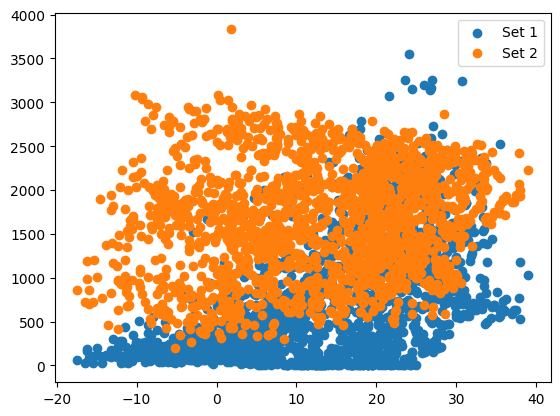

In [434]:
import matplotlib.pyplot as plt

best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))

inputs = [[test_data['Windspeed'][i], test_data['Visibility'][i], test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i]] for i in range(len(test_data))]
# Assuming you have two sets of data:
x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([-1341.43062631]), array([-1566.79924646]), array([-1868.64410125]), array([-653.59018902]), array([-992.38845207]), array([-3091.24124417]), array([484.19225745]), array([-1597.52885561]), array([221.9523784]), array([-831.00966057]), array([-358.22429912]), array([8.97270141]), array([-224.50605769]), array([-1680.8769766]), array([-505.08495231]), array([325.59093221]), array([64.67429338]), array([-1273.69840813]), array([-514.75403905]), array([-1826.40372784]), array([296.27322959]), array([163.16319708]), array([400.03305997]), array([298.50015364]), array([-902.30862306]), array([432.18916063]), array([-682.68614968]), array([474.57859593]), array([-144.14423847]), array([-788.00261475]), array([248.27934106]), array([243.92054566]), array([-851.47735328]), array([75.07933842]), array([-1078.48939223]), array([637.21007139]), array([386.94033426]), array([-947.02572962]), array([755.94609833]), array([-212.25226736]), array([-290.78490428]), array([-1172.59736531]), arra

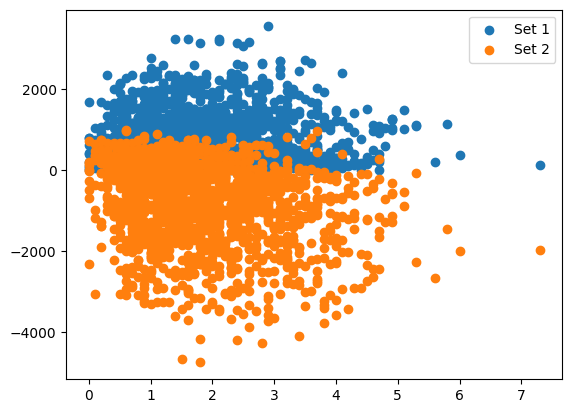

In [431]:
# Assuming you have two sets of data:
x_values1 = test_data['Windspeed'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Windspeed'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([-1341.43062631]), array([-1566.79924646]), array([-1868.64410125]), array([-653.59018902]), array([-992.38845207]), array([-3091.24124417]), array([484.19225745]), array([-1597.52885561]), array([221.9523784]), array([-831.00966057]), array([-358.22429912]), array([8.97270141]), array([-224.50605769]), array([-1680.8769766]), array([-505.08495231]), array([325.59093221]), array([64.67429338]), array([-1273.69840813]), array([-514.75403905]), array([-1826.40372784]), array([296.27322959]), array([163.16319708]), array([400.03305997]), array([298.50015364]), array([-902.30862306]), array([432.18916063]), array([-682.68614968]), array([474.57859593]), array([-144.14423847]), array([-788.00261475]), array([248.27934106]), array([243.92054566]), array([-851.47735328]), array([75.07933842]), array([-1078.48939223]), array([637.21007139]), array([386.94033426]), array([-947.02572962]), array([755.94609833]), array([-212.25226736]), array([-290.78490428]), array([-1172.59736531]), arra

ValueError: x and y must be the same size

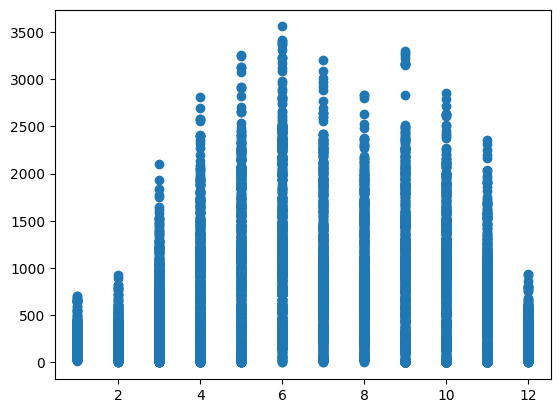

In [432]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()